In [1]:
import numpy as np
import glob
import os
from opac_mixer.read import ReadOpacChubb
from opac_mixer.mix import CombineOpacGrid
from opac_mixer.emulator import DEFAULT_PRANGE, DEFAULT_TRANGE, DEFAULT_MMR_RANGES

import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer

from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown

from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, ElasticNet, MultiTaskElasticNetCV, LassoLars, LassoLarsCV, RidgeCV
from sklearn.linear_model._base import LinearModel
import m2cgen
from sklearn.model_selection import train_test_split
from MITgcmutils import wrmds
import matplotlib.colors as mcolors
from itertools import combinations
import time

from xgboost import XGBRegressor

import scipy.integrate

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

from scipy.stats import qmc

%matplotlib inline

2023-05-01 14:02:16.579792: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# DEFAULT_MMR_RANGES = {
#     'CO': (1e-20, 0.005522337070205542),
#     'H2O': (1e-20, 0.0057565911404275204),
#     'HCN': (1e-20, 9.103077483740115e-05),
#     'C2H2,acetylene': (1e-20, 1.581540423097846e-05),
#     'CH4': (1e-20, 0.0031631031028604537),
#     'PH3': (1e-20, 6.401082202603451e-06),
#     'CO2': (1e-20, 0.00015319944152172055),
#     'NH3': (1e-20, 0.00084362326521647),
#     'H2S': (1e-20, 0.0003290905470710346),
#     'VO': (1e-20, 1.6153195092178982e-07),
#     'TiO': (1e-20, 3.925184850731112e-06),
#     'Na': (1e-20, 2.524986071526357e-05),
#     'K': (1e-20, 1.932224843084919e-06),
#     'SiO': (1e-20, 0.0010448970102509476),
#     'FeH': (1e-20, 0.000203477300968298)
# }

In [3]:
# R_10='10'
R_S1='S1'
base = f'{os.environ["pRT_input_data_path"]}/opacities/lines/corr_k'
# files_10 = glob.glob(os.path.join(base,f'*_R_{R_10}/*.h5'))
files_S1 = glob.glob(os.path.join(base,f'*_R_{R_S1}/*.h5'))
# files = ['/Users/schneider/codes/exo/prt_input_data/opacities/lines/corr_k/TiO_all_Exomol_R_S1/TiO_all_Exomol_R_S1.h5','/Users/schneider/codes/exo/prt_input_data/opacities/lines/corr_k/H2O_Exomol_R_S1/H2O_Exomol_R_S1.h5']
# batchsize = int(2**14)
batchsize = 4000

load = False
load_model = False

In [4]:
class IndiEmulator:
    def __init__(self, opac, prange_opacset=DEFAULT_PRANGE, trange_opacset=DEFAULT_TRANGE):
        self.opac = opac
        if not self.opac.read_done:
            self.opac.read_opac()
        if not self.opac.interp_done:
            self.opac.setup_temp_and_pres(pres=np.logspace(np.log(prange_opacset[0]),np.log(prange_opacset[1]), 5),
                                          temp=np.linspace(*trange_opacset, 5))

        self.mixer = CombineOpacGrid(self.opac)
        self._input_dim = int(self.opac.ls)
        
        
    def setup_sampling_grid(self, batchsize=16384, bounds={}):
        """
        Setup the sampling grid. Sampling along MMR and pressure is in logspace.
        Sampling along temperature is in linspace.

        Dimension of a sample: (mmr_0, .., mmr_n, p, T)

        Parameters
        ----------
        batchsize: int
            Number of total sampling points. Needs to be a power of 2 for sobol sampling
        bounds: dict
            the lower and upper bounds for sampling. Shape: {'species':(lower, upper)}
            The key can be either a species name in opac.spec or p and T for pressure and Temperature.
            It will use opac_mixer.emulator.DEFAULT_MMR_RANGES for mmrs, opac_mixer.emulator.DEFAULT_PRANGE for pressure,
            and opac_mixer.emulator.DEFAULT_TRANGE for temperautre for all missing values

        Returns
        -------
        """
        # make sure the filename comes without the npy suffix
        self.batchsize = batchsize

        l_bounds = []
        u_bounds = []
        for sp in self.opac.spec:
            if sp not in DEFAULT_MMR_RANGES and sp not in bounds:
                raise ValueError(f"We miss the bounds for {sp}.")

            default_l, default_u = DEFAULT_MMR_RANGES.get(sp)
            l, u = bounds.get(sp, (default_l, default_u))
            l_bounds.append(np.maximum(l, 1.0e-20))
            u_bounds.append(u)
        
        # Use a standard uniform distribution
        sample = np.random.uniform(low=0.0, high=1.0, size=(batchsize, self._input_dim, self.opac.lp[0], self.opac.lt[0]))

        # Scale the sampling to the actual bounds
        # Note: We use loguniform like scaling for mmrs + pressure and a uniform like scaling for the temperature (last column/feature)
        
        shape = (batchsize, self._input_dim, self.opac.lp[0], self.opac.lt[0])
        
        self.input_data = np.empty(shape)
        self.input_data = np.exp(sample[:,:,:,:] * (np.log(u_bounds)[np.newaxis,:,np.newaxis, np.newaxis]-np.log(l_bounds)[np.newaxis,:,np.newaxis, np.newaxis]) + np.log(l_bounds)[np.newaxis,:,np.newaxis, np.newaxis])

        # Use ones instead (same abundancy)
        # self.input_data = np.ones(shape)        
        
        weighted_kappas = self.input_data[:,:, :, :, np.newaxis, np.newaxis]*self.opac.kcoeff[np.newaxis, ...]

        self._check_input_data(self.input_data)

        self._has_input = True

        return weighted_kappas

    def _check_input_data(self, input_data):
        pass
    
    def setup_mix(self, test_size=0.2, split_seed =None, do_parallel=True):
        """
        Setup the mixer and generate the training and testdata.

        Parameters
        ----------
        test_size: float
            fraction of data used for testing
        split_seed: int
            A seed to be used for shuffling training and test data before splitting
        do_parallel:
            If you want to create the data in parallel or not
        """
        if not self._has_input:
            raise AttributeError('we do not have input yet. Run setup_sampling_grid first.')

        # make sure the filename comes without the npy suffix
        if do_parallel:
            mix = self.mixer.add_batch_parallel(self.input_data).reshape(
                (self.batchsize,self.opac.lp[0],self.opac.lt[0],self.opac.lf[0], self.opac.lg[0]))
        else:
            mix = self.mixer.add_batch(self.input_data).reshape(
                (self.batchsize,self.opac.lp[0],self.opac.lt[0],self.opac.lf[0], self.opac.lg[0]))

        if split_seed is None:
            split_seed = np.random.randint(2**32 - 1)
            
        return mix

In [5]:
def gen_linear_features_all(files):
    X = []
    y = []   
    opac = ReadOpacChubb(files)
    emulator = IndiEmulator(opac)
    batchsize_cor = batchsize//emulator.opac.lf[0]  
    kappas = emulator.setup_sampling_grid(batchsize=batchsize_cor, use_sobol=False).transpose((0,2,3,4,1,5))
    mix = emulator.setup_mix(do_parallel=True)
    batchresh = batchsize_cor*emulator.opac.lp[0]*emulator.opac.lt[0]*emulator.opac.lf[0]
    X_r = kappas.reshape(batchresh, emulator.opac.ls, emulator.opac.lg[0])
    yi = mix.reshape(batchresh, emulator.opac.lg[0])
    X.append(X_r)
    y.append(yi)
    X = np.asarray(X).reshape(len(X)*batchresh, emulator.opac.ls, emulator.opac.lg[0]).transpose(0,2,1)
    y = np.asarray(y).reshape(len(y)*batchresh, emulator.opac.lg[0])
    return X, y 

def gen_linear_features(files):
    X = []
    y = []
    for i,j in combinations(range(len(files)),2):    
        files_i = [files[i],files[j]]
        opac = ReadOpacChubb(files_i)
        emulator = IndiEmulator(opac, )
        kappas = emulator.setup_sampling_grid(batchsize=batchsize, use_sobol=False).transpose((0,2,3,4,1,5))
        mix = emulator.setup_mix(do_parallel=False)
        batchresh = batchsize*emulator.opac.lp[0]*emulator.opac.lt[0]*emulator.opac.lf[0]
        X_r = kappas.reshape(batchresh, emulator.opac.ls, emulator.opac.lg[0])
        yi = mix.reshape(batchresh, emulator.opac.lg[0])
        X.append(X_r)
        y.append(yi)
    X = np.asarray(X).reshape(len(X)*batchresh, 2, emulator.opac.lg[0]).transpose(0,2,1)
    y = np.asarray(y).reshape(len(y)*batchresh, emulator.opac.lg[0])
    return X, y 

In [6]:
X_S1, y_S1 = gen_linear_features_all(files_S1)
# X_10, y_10 = gen_linear_features_all(files_10)
# X = np.concatenate([X_S1, X_10], axis=0)
# y = np.concatenate([y_S1, y_10], axis=0)

X=X_S1
y=y_S1

# X, y= gen_linear_features()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=None)

TypeError: IndiEmulator.setup_sampling_grid() got an unexpected keyword argument 'use_sobol'

In [ ]:
def get_simple_1d_conv(ng, num_species):
    model = keras.Sequential()
    model.add(layers.Input(shape=(ng, num_species)))
    layers.Permute((2, 1), input_shape=(ng, num_species)),
    model.add(layers.Conv1D(filters=4, kernel_size=3, activation='linear', padding='same'))
    model.add(layers.Conv1D(filters=4, kernel_size=3, activation='linear', padding='same'))
    model.add(layers.Conv1D(filters=1, kernel_size=3, activation='linear', padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=ng, activation='linear'))
    return model

def get_simple_mlp(ng):
    model = keras.Sequential()
    model.add(layers.Input(shape=(ng, None)))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=ng, activation='relu'))
    model.add(layers.Dense(units=ng, activation='relu'))
    model.add(layers.Dense(units=ng, activation='relu'))
    model.add(layers.Dense(units=ng, activation='linear'))
    return model


def get_reasonable_1d_conv_no_dense(ng):
    model = keras.Sequential([
        layers.Conv1D(filters=8, kernel_size=2, activation='relu', input_shape=(ng,2), padding='same',),
        layers.Conv1D(filters=4, kernel_size=2, activation='relu', input_shape=(ng,2), padding='same',),
        layers.Conv1D(filters=1, kernel_size=2, activation='linear', padding='same'),
    ])
    
    return model    

def get_encoder_decoder(ng):
    model = keras.Sequential([
        layers.Input(shape=(ng, None)),
        layers.Permute((2, 1), input_shape=(ng, None)),
        layers.Dense(units = ng, activation = 'relu', use_bias=False),
        layers.Lambda(lambda x: tf.reduce_sum(x, axis=-2)),
        layers.Dense(units = ng, activation = 'linear', use_bias=False),
    ])
    return model

def get_encoder_decoder_conv(ng, species):
    # Define CNN layers to process each instance in the set
    model = keras.Sequential([
        layers.Input(shape=(ng, species)),
        layers.Conv1D(filters=4, kernel_size=3, activation='relu'),
        layers.Conv1D(filters=4, kernel_size=3, activation='relu'),
        layers.Conv1D(filters=4, kernel_size=3, activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(units=16, activation='linear')
    ])
    return model

def get_unet_1d(ng, species, min_filters = 8):
    input_layer = layers.Input(shape=(ng, species))

    conv1 = layers.Conv1D(min_filters, 3, activation='relu', padding='same')(input_layer)
    conv1 = layers.Conv1D(min_filters, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling1D(2)(conv1)

    conv2 = layers.Conv1D(2*min_filters, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv1D(2*min_filters, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling1D(2)(conv2)

    conv3 = layers.Conv1D(4*min_filters, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv1D(4*min_filters, 3, activation='relu', padding='same')(conv3)

    up4 = layers.Conv1DTranspose(2*min_filters, 2, strides=2, padding='same')(conv3)
    concat4 = layers.concatenate([conv2, up4], axis=-1)
    conv4 = layers.Conv1DTranspose(2*min_filters, 3, activation='relu', padding='same')(concat4)
    conv4 = layers.Conv1DTranspose(2*min_filters, 3, activation='relu', padding='same')(conv4)

    up5 = layers.Conv1DTranspose(min_filters, 2, strides=2, padding='same')(conv4)
    concat5 = layers.concatenate([conv1, up5], axis=-1)
    conv5 = layers.Conv1DTranspose(min_filters, 3, activation='relu', padding='same')(concat5)
    conv5 = layers.Conv1DTranspose(min_filters, 3, activation='relu', padding='same')(conv5)

    output_layer = layers.Conv1D(1, 3, activation='linear', padding='same')(conv5)
    output_layer = layers.Flatten()(output_layer)

    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model

def get_unet_1d_small(ng, min_filters = 4):
    input_layer = layers.Input(shape=(ng, 2))

    conv1 = layers.Conv1D(min_filters, 3, activation='relu', padding='same')(input_layer)
    conv1 = layers.Conv1D(min_filters, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling1D(2)(conv1)

    conv2 = layers.Conv1D(2*min_filters, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv1D(2*min_filters, 3, activation='relu', padding='same')(conv2)

    up3 = layers.UpSampling1D(2)(conv2)
    conv3 = layers.Conv1DTranspose(min_filters, 3, activation='relu', padding='same')(up3)
    conv3 = layers.Conv1DTranspose(min_filters, 3, activation='relu', padding='same')(conv3)

    output_layer = layers.Conv1D(1, 3, activation='linear', padding='same')(conv3)
    output_layer = layers.Flatten()(output_layer)

    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model

def get_xgboost(ng):
    return XGBRegressor(max_depth=6, n_estimators=10, tree_method='hist')

def logFunc(x):
   return keras.backend.log(x) + 1e-30
    

def get_simple_conv(ng):
    input_layer = layers.Input(shape=(ng, 16))
    conv1 = layers.Conv1D(1, 4, activation='relu', padding='same')(input_layer)
    flat = layers.Flatten()(conv1)
    model = keras.Model(inputs=input_layer, outputs=flat)
    return model

In [ ]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
# model = get_encoder_decoder(16)
# model = chatgpts_cnn(16,14)
# model = get_unet_1d_small(16)
# model = get_simple_1d_conv_no_dense(16)
# model = get_reasonable_1d_conv_no_dense(16)
# model = get_unet_1d_small(16)
# model = get_simple_conv(16)

# model = RidgeCV(fit_intercept=False, cv=5)
# model = LinearRegression(fit_intercept=True)
model = get_encoder_decoder(16)
# model = get_encoder_decoder_conv(16, 14)
# model = get_xgboost(16)
# model = get_LSTM(16)
# model = get_attention([14,16],16,16)
# model = get_simple_1d_conv(16,14)
# model = get_reasonable_1d_conv_no_dense(16)
# model = get_xgboost(16)
# model = get_simple_conv(16)
# model = get_unet_1d(16,14)

# model = LassoLarsCV(fit_intercept=False, positive=True)
# model = LinearRegression(fit_intercept=False, positive=True)

if isinstance(model, keras.Model):
    model.compile(optimizer=keras.optimizers.Adam(lr=0.1), loss="mean_squared_error")
    model.summary()

2023-05-01 13:23:46.171620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, None, 16)          0         
                                                                 
 dense (Dense)               (None, None, 16)          256       
                                                                 
 lambda (Lambda)             (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                256       
                                                                 
Total params: 512
Trainable params: 512
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def diff(vals, do_log=False):
    diffvals = np.diff(vals, axis=1)
    zero_val = vals[:,0]
    if do_log:
        diffvals = np.log(diffvals+1e-45)
        zero_val = np.log(vals[:,0]+1e-45)

    if len(vals.shape) == 3:
        return np.concatenate((zero_val[:,None,:], diffvals), axis=1)
    else:
        return np.concatenate((zero_val[:,None], diffvals), axis=-1)
    

def integrate_diff(diff_vals, do_log=False):
    """Integrate along last axis to invert np.diff"""
    
    rev_diff = diff_vals
    if do_log:
        rev_diff = np.exp(diff_vals)-1e-45

    intdiff = np.cumsum(rev_diff[:,1:], axis=-1)+rev_diff[:,0][:,None]
    # assert np.all(intdiff >= diff_vals[:,0][:,None])
    int_res = np.concatenate((rev_diff[:,0][:,None], intdiff), axis=-1)
    # return np.where(int_res>0, int_res, 1e-45)
    return int_res



y_test_diff = diff(y_test)
np.testing.assert_allclose(integrate_diff(y_test_diff), y_test)
# integrate_diff(y_test_diff)[0], y_test[0]

In [ ]:
# conv_add = X_test[:,:,0][:,None,:]+X_test[:,:,1][:,:,None]

def do_convolve(X, n=3):
    tot_i = 0
    conv_add = np.zeros((len(X), (2*n+1)*16))
    for i in range(16):
        for k in range(-n,n+1):
            if (i + k) > 0 and (i+k) < 16:
                conv_add[:, tot_i] = X[:, i, 0] + X[:, i+k, 1]
                tot_i += 1

    return conv_add[:,:tot_i]


In [ ]:
def transform_x_outer_add(X, log=False, reshape=False):
    xouter = X[:,:,0][:,None,:]+X[:,:,1][:,:,None]
    if log:
        xouter = np.log(xouter)
    if reshape:
        xouter = xouter.reshape(len(X),-1)
    return xouter


def transform_x_outer_add_min(X, log=False, reshape=False):
    xouter = X[:,:,0][:,None,:]+X[:,:,1][:,:,None]
    if log:
        xouter = np.log(xouter)
    if reshape:
        xouter = xouter.reshape(len(X),-1)
    return xouter

def transform_x_convolve(X):
    return np.log(do_convolve(X))

def transform_x_scaled(X):
    xlargest = X.sum(axis=-1)[:,-1]
    return X/xlargest[:, None, None] 

def transform_y_scaled(X, y):
    xlargest = X.sum(axis=-1)[:,-1]
    return y/xlargest[:, None]

def inverse_transform_y_scaled(X, y):
    xlargest = X.sum(axis=-1)[:,-1]
    return y*xlargest[:, None]


def transform_x_sum(X, do_log=False):
    xsum = X.sum(axis=-1)
    transformed = X-xsum[:,:,None]
    if do_log:
        transformed = np.log(X/xsum[:,:,None])

    return transformed

def transform_y_sum(X, y, do_log = False):
    xsum = X.sum(axis=-1)
    transformed = y-xsum
    if do_log:
        transformed = np.log(y/xsum)
    return transformed

def inverse_transform_y_sum(X, y, do_log=False):
    xsum = X.sum(axis=-1)
    if do_log:
        return np.exp(y)*xsum
    else:
        return y+xsum




def transform_x_divide(X):
    return X/X[:,-1,:][:,None,:]

def transform_y_divide_sum(X, y):
    xsum = X.sum(axis=-1)
    return (y-xsum)/(xsum[:,-1][:,None]+1)

def inverse_transform_y_divide_sum(X, y):
    xsum = X.sum(axis=-1)
    return (xsum[:,-1][:,None]+1)*y + xsum

def transform_x_diff_log(X, do_log=True):
    return diff(X,do_log=do_log)

def transform_y_diff_log_sum(X, y, do_log=True):
    xsum = X.sum(axis=-1)
    if do_log:
        return diff(y, do_log=True) - diff(xsum, do_log=True)
    else:
        return diff((y - xsum)/(xsum[:,-1][:,None]+1), do_log=False)

def inverse_transform_y_diff_log_sum(X, y, do_log=True):
    xsum = X.sum(axis=-1)
    if do_log:
        return integrate_diff(y + diff(xsum, do_log=True), do_log=True)
    else:
        return (xsum[:,-1][:,None]+1)*integrate_diff(y, do_log=False) + xsum



In [ ]:
def t_x(X):
    # return transform_x_convolve(X)
    # return transform_x_outer_add(transform_x_scaled(X), reshape=False, log=True)
    # return diff(transform_x_scaled(X), do_log=False)
    # return np.log(X)
    return transform_x_sum(X, do_log=True)
    # return transform_x_scaled(X)
    # return transform_x_outer_add(X, log=True, reshape=True)
    # return transform_x_divide(X)
    # return diff(X, do_log=True)
    # return transform_x_diff_log(X, do_log=False)

def t_y(X, y):
    # return transform_y_scaled(X,y)
    # return diff(transform_y_scaled(X,y),do_log=False)
    return transform_y_sum(X, y, do_log=True)
    # return np.log(y)
    # return transform_y_divide_sum(X, y)
    # return diff(y, do_log=True)
    # return transform_y_diff_log_sum(X, y, do_log=False)

def ti_y(X, y):
    # return np.exp(y)
    # return inverse_transform_y_scaled(X,integrate_diff(y, do_log=False))
    return inverse_transform_y_sum(X, y, do_log=True)
    # return inverse_transform_y_scaled(X,y)
    # return np.exp(y)
    # return inverse_transform_y_divide_sum(X, y)
    # return integrate_diff(y, do_log=True)
    # return inverse_transform_y_diff_log_sum(X, y, do_log=False)


np.testing.assert_allclose(ti_y(X_train,t_y(X_train,y_train)), y_train)
np.testing.assert_allclose(ti_y(X_test,t_y(X_test,y_test)), y_test)



In [ ]:
def logerr(y_true, y_pred):
    mask = y_pred > 0
    try:
        return mean_squared_error(np.log(y_true[mask]), np.log(y_pred[mask]))
    except ValueError:
        return np.nan

def logr2(y_true, y_pred):
    mask = y_pred > 0
    try:
        return r2_score(np.log(y_true[mask]), np.log(y_pred[mask]))
    except ValueError:
        return np.nan

class CustomCallback(keras.callbacks.Callback):
    def __init__(self, validations_sets, num_test=10000, errorfuncs=[logerr, logr2]):
        super().__init__()
        self.validation_sets = []
        for X,y in validations_sets:
            valset = (X,y, np.random.randint(len(y), size=min([num_test, len(y)])))
            self.validation_sets.append(valset)
        self.errorfuncs = errorfuncs

    def on_epoch_end(self, epoch, logs=None):
        errs = []
        for X_test, y_test, ti in self.validation_sets:

            y_pred = ti_y(X_test[ti], self.model.predict(t_x(X_test[ti]), verbose=0))
            
            errs.append([err(y_test[ti], y_pred) for err in self.errorfuncs])

        val_err_str = "(" + "); (".join([", ".join(["{:.2e}".format(err) for err in errs_i]) for errs_i in errs]) + ")"
        loss = logs['loss']
        print(f"Epoch: {epoch}, loss: {loss:.2e}, val_error: {val_err_str}")

In [ ]:
if isinstance(model, keras.Model):
    model.fit(t_x(X_train), t_y(X_train, y_train), callbacks=[CustomCallback([(X_test, y_test)]),keras.callbacks.EarlyStopping(monitor='loss', patience=3)], epochs=100, batch_size=32, verbose=0)
else:
    model.fit(t_x(X_train).reshape(len(X_train),-1), t_y(X_train, y_train))

Epoch: 0, loss: 3.98e+02, val_error: (4.34e+00, 9.46e-01)
Epoch: 1, loss: 2.00e+00, val_error: (8.82e-01, 9.89e-01)
Epoch: 2, loss: 7.78e-01, val_error: (6.37e-01, 9.92e-01)
Epoch: 3, loss: 6.30e-01, val_error: (5.35e-01, 9.93e-01)
Epoch: 4, loss: 5.41e-01, val_error: (4.61e-01, 9.94e-01)
Epoch: 5, loss: 5.06e-01, val_error: (4.89e-01, 9.94e-01)
Epoch: 6, loss: 4.73e-01, val_error: (4.28e-01, 9.95e-01)
Epoch: 7, loss: 4.47e-01, val_error: (3.88e-01, 9.95e-01)
Epoch: 8, loss: 4.31e-01, val_error: (3.81e-01, 9.95e-01)
Epoch: 9, loss: 4.27e-01, val_error: (3.77e-01, 9.95e-01)
Epoch: 10, loss: 4.20e-01, val_error: (3.69e-01, 9.95e-01)
Epoch: 11, loss: 4.18e-01, val_error: (3.75e-01, 9.95e-01)
Epoch: 12, loss: 4.14e-01, val_error: (3.74e-01, 9.95e-01)
Epoch: 13, loss: 4.09e-01, val_error: (3.76e-01, 9.95e-01)
Epoch: 14, loss: 4.10e-01, val_error: (3.70e-01, 9.95e-01)
Epoch: 15, loss: 4.10e-01, val_error: (3.68e-01, 9.95e-01)
Epoch: 16, loss: 4.06e-01, val_error: (3.83e-01, 9.95e-01)
Epoch: 

In [ ]:
if isinstance(model, keras.Model):
    y_p_test = ti_y(X_test, model.predict(t_x(X_test)))
    y_p_train = ti_y(X_train, model.predict(t_x(X_train)))
else:
    y_p_test = ti_y(X_test, model.predict(t_x(X_test).reshape(len(X_test),-1)))
    y_p_train = ti_y(X_train, model.predict(t_x(X_train).reshape(len(X_train),-1)))

4975/4975 [==============================] - 5s 980us/step


In [ ]:
train_mask = (y_train>1e-45)
test_mask = (y_test>1e-45)

log_err_out = (y_p_train[train_mask] > 0).all()

y_add_test = np.sum(X_test, axis=-1)
y_add_train = np.sum(X_train, axis=-1)

y_test_masked = y_test[test_mask]
y_train_masked = y_train[train_mask]
y_p_test_masked = y_p_test[test_mask]
y_p_train_masked = y_p_train[train_mask]
y_add_test_masked = y_add_test[test_mask]
y_add_train_masked = y_add_train[train_mask]

e_add_test = np.sqrt(mean_squared_error(y_test_masked, y_add_test_masked))
e_add_train = np.sqrt(mean_squared_error(y_train_masked, y_add_train_masked))
e_p_test = np.sqrt(mean_squared_error(y_test_masked, y_p_test_masked))
e_p_train = np.sqrt(mean_squared_error(y_train_masked, y_p_train_masked))

if log_err_out:
    e_log_add_test = np.sqrt(mean_squared_log_error(y_test_masked, y_add_test_masked))
    e_log_add_train = np.sqrt(mean_squared_log_error(y_train_masked, y_add_train_masked))
    e_log_p_test = np.sqrt(mean_squared_log_error(y_test_masked, y_p_test_masked))
    e_log_p_train = np.sqrt(mean_squared_log_error(y_train_masked, y_p_train_masked))

r2_add_test = r2_score(y_test_masked, y_add_test_masked)
r2_add_train = r2_score(y_train_masked, y_add_train_masked)
r2_p_test = r2_score(y_test_masked, y_p_test_masked)
r2_p_train = r2_score(y_train_masked, y_p_train_masked)

if log_err_out:
    r2_log_add_test = r2_score(np.log(y_test_masked), np.log(y_add_test_masked))
    r2_log_add_train = r2_score(np.log(y_train_masked), np.log(y_add_train_masked))
    r2_log_p_test = r2_score(np.log(y_test_masked), np.log(y_p_test_masked))
    r2_log_p_train = r2_score(np.log(y_train_masked), np.log(y_p_train_masked))


print("test           (add, model): {:.2e}, {:.2e}".format(e_add_test, e_p_test))
print("train          (add, model): {:.2e}, {:.2e}".format(e_add_train, e_p_train))
if log_err_out:
    print("log test       (add, model): {:.2e}, {:.2e}".format(e_log_add_test, e_log_p_test))
    print("log train      (add, model): {:.2e}, {:.2e}".format(e_log_add_train, e_log_p_train))
print("r2 test        (add, model): {:.2e}, {:.2e}".format(r2_add_test, r2_p_test))
print("r2 train       (add, model): {:.2e}, {:.2e}".format(r2_add_train, r2_p_train))
if log_err_out:
    print("log r2 test    (add, model): {:.2e}, {:.2e}".format(r2_log_add_test, r2_log_p_test))
    print("log r2 train   (add, model): {:.2e}, {:.2e}".format(r2_log_add_train, r2_log_p_train))

test           (add, model): 9.45e-02, 7.99e-01
train          (add, model): 1.11e-01, 9.50e-01
log test       (add, model): 8.63e-03, 2.04e-02
log train      (add, model): 8.65e-03, 1.94e-02
r2 test        (add, model): 1.00e+00, 1.00e+00
r2 train       (add, model): 1.00e+00, 9.99e-01
log r2 test    (add, model): 9.78e-01, 9.95e-01
log r2 train   (add, model): 9.77e-01, 9.95e-01


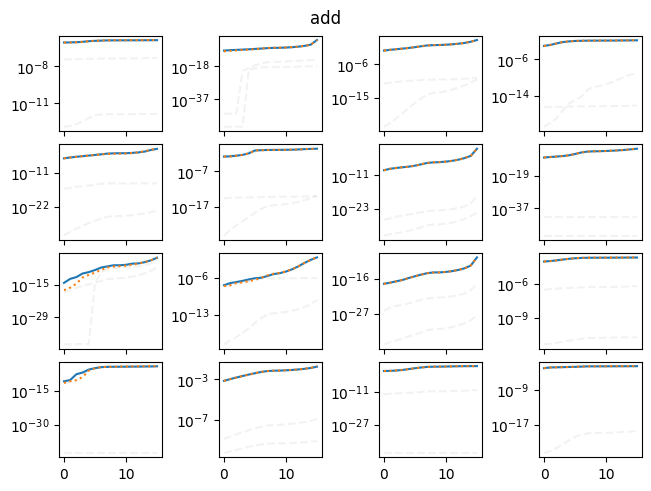

In [ ]:
indexes = np.random.randint(len(y_test), size=16)

fig, axes = plt.subplots(4,4, constrained_layout=True, sharex=True)
fig.suptitle('add')

for i, ax in enumerate(axes.flat):
    index = indexes[i]
    ax.plot(X_test[index,:,0], alpha=0.1, ls='--', c='gray')
    ax.plot(X_test[index,:,1], alpha=0.1, ls='--', c='gray')
    ax.plot(y_test[index], alpha=1.0,ls ='-')
    ax.plot(y_add_test[index], alpha=1.0, ls=':')
    ax.set_yscale('log')
plt.show()

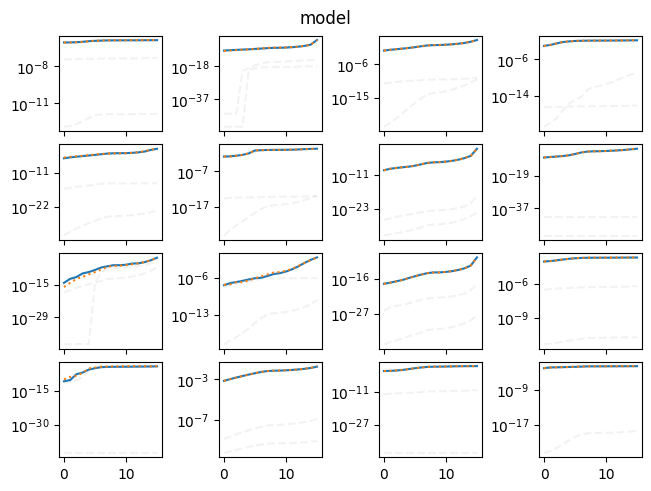

In [ ]:
fig, axes = plt.subplots(4,4, constrained_layout=True, sharex=True)
fig.suptitle('model')
for i, ax in enumerate(axes.flat):
    index = indexes[i]
    ax.plot(X_test[index,:,0], alpha=0.1, ls='--', c='gray')
    ax.plot(X_test[index,:,1], alpha=0.1, ls='--', c='gray')
    ax.plot(y_test[index], alpha=1.0,ls ='-')
    ax.plot(y_p_test[index], alpha=1.0, ls=':')
    ax.set_yscale('log')
plt.show()

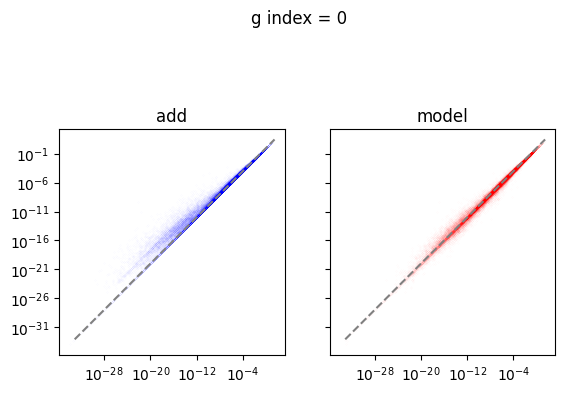

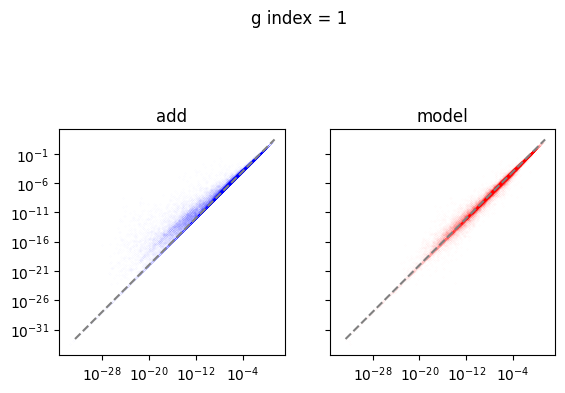

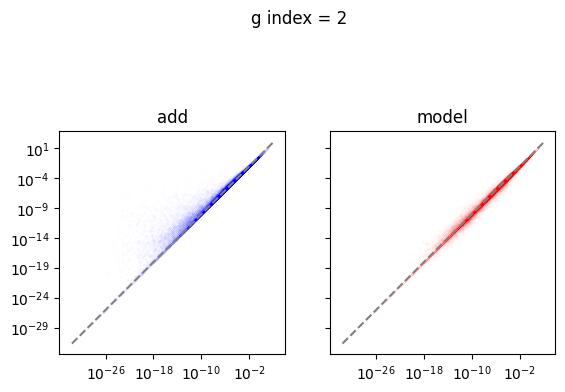

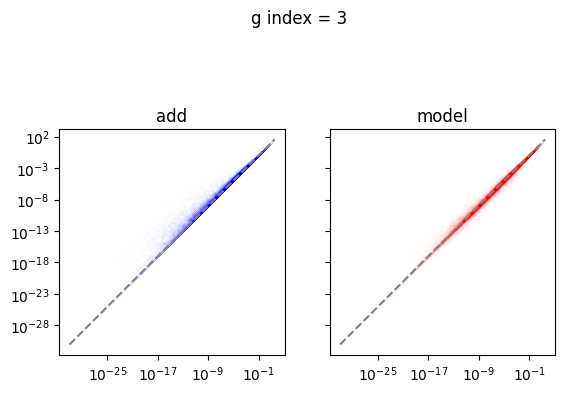

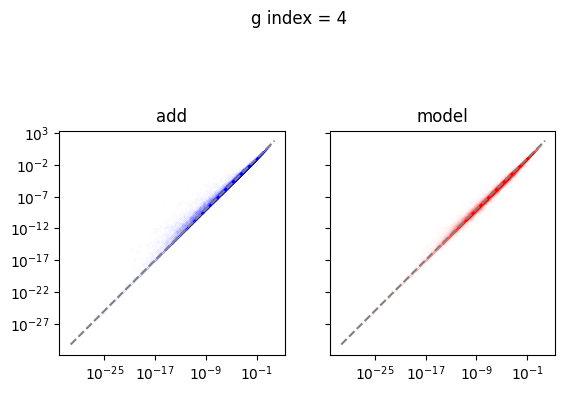

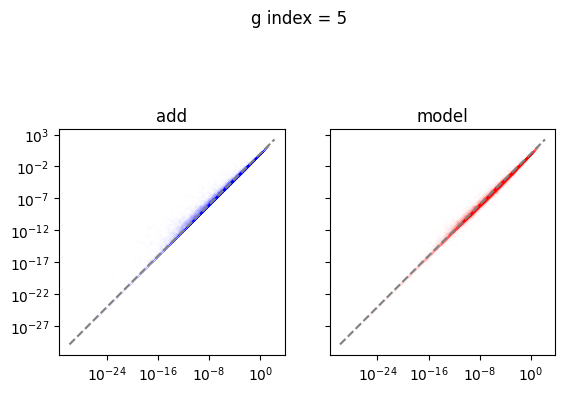

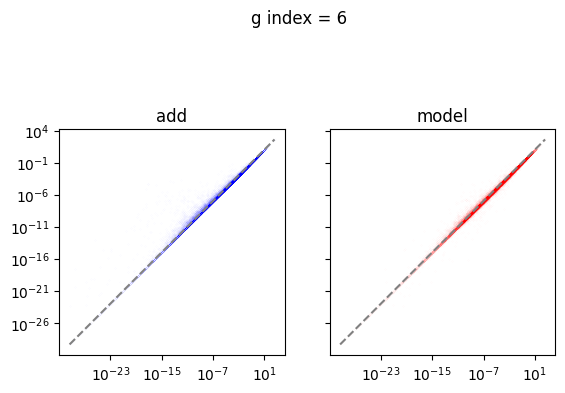

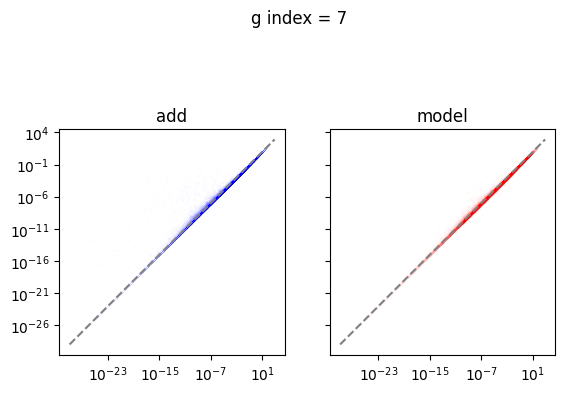

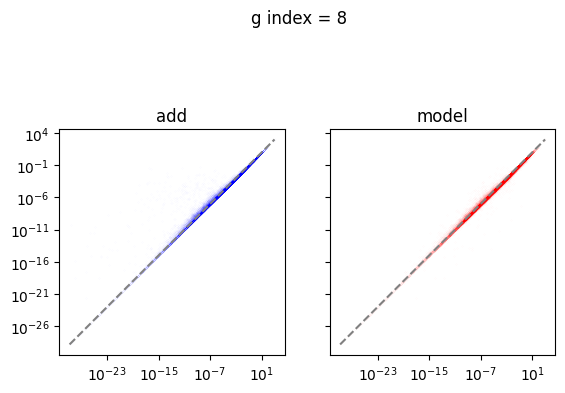

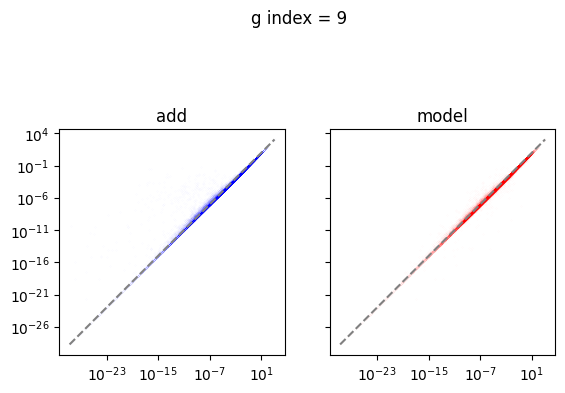

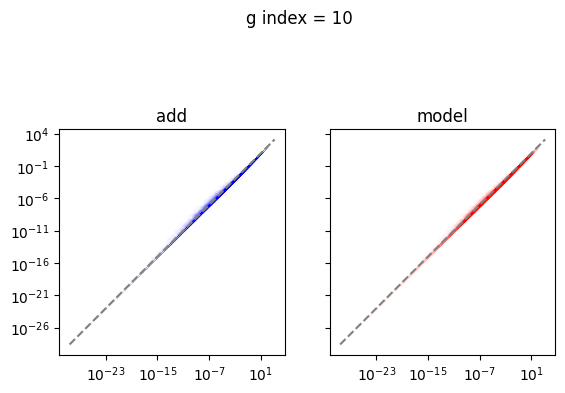

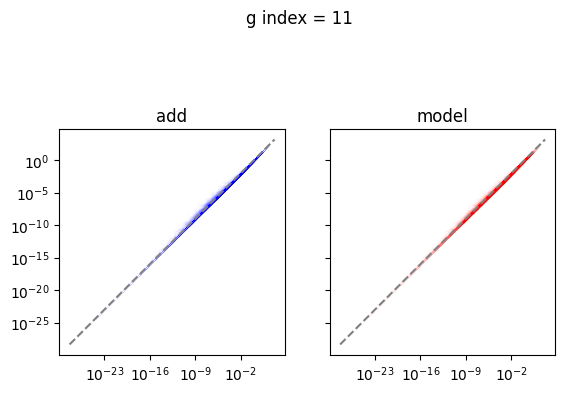

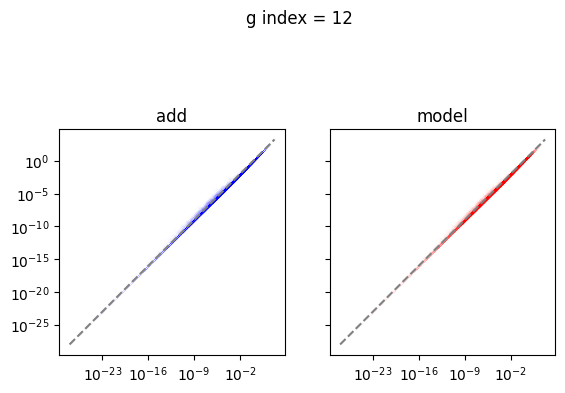

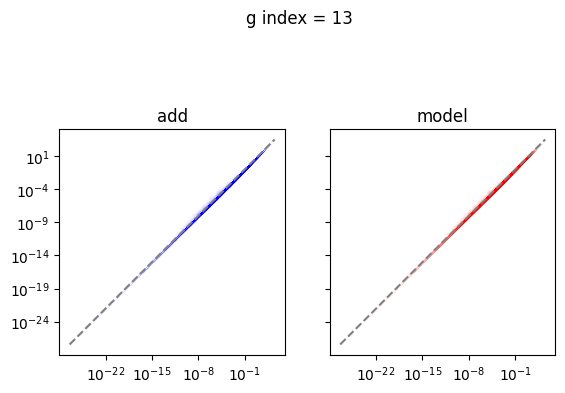

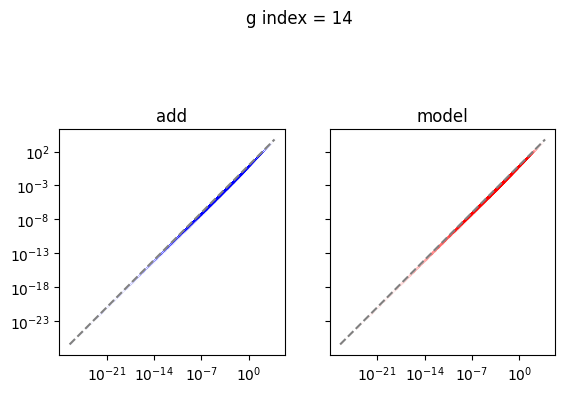

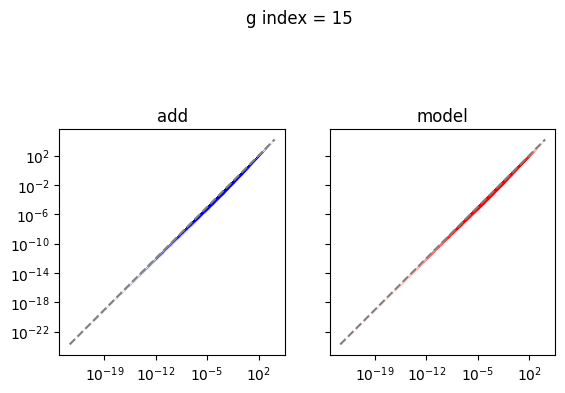

In [ ]:
for index in range(y_p_test.shape[-1]):
    fig,axes = plt.subplots(1,2, sharex=True, sharey=True)
    
    axes[0].plot(y_add_test[:, index], y_test[:, index],'bo', ms=0.01, linestyle="None")    
    axes[1].plot(y_p_test[:, index], y_test[:, index],'ro', ms=0.01, linestyle="None")
    fig.suptitle(f'g index = {index}')
    axes[0].set_title('add')
    axes[1].set_title('model')
    
    for ax in axes:
        ax.plot([y_p_test[:, index].min(), y_p_test[:, index].max()], [y_p_test[:, index].min(), y_p_test[:, index].max()], color = 'gray', ls = '--')    
        ax.set_xscale('log')
        ax.set_yscale('log')    
        ax.set_aspect('equal')
        
    
    plt.show()

In [ ]:
mlp_weights = [weights.numpy() for weights in model.weights]
def simple_mlp(kappas):
    rep = np.tensordot(kappas, mlp_weights[0], axes=(1,0))  # first dense
    rep[rep <= 0.0] = 0.0
    print(rep.shape)
    sum_rep = np.sum(rep, axis=1)   # sum
    dec = np.tensordot(sum_rep, mlp_weights[1], axes=(-1,0))  # second dense
    return dec

# np.testing.assert_allclose(simple_mlp(t_x(X_test)), model.predict(t_x(X_test)))

In [ ]:
t_x(X_test).shape

(39800, 16, 14)

In [ ]:


np.testing.assert_allclose(ti_y(X_test, simple_mlp(t_x(X_test))), ti_y(X_test, model.predict(t_x(X_test))))

(39800, 14, 16)
1244/1244 [==============================] - 1s 1ms/step


AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 100943 / 636800 (15.9%)
Max absolute difference: 0.00041009
Max relative difference: 8.69406193e-06
 x: array([[3.705781e-04, 7.366939e-04, 1.223919e-03, ..., 3.450208e+01,
        2.007163e+02, 2.464160e+03],
       [3.485693e-05, 7.323541e-05, 1.359036e-04, ..., 6.249311e-03,...
 y: array([[3.705781e-04, 7.366940e-04, 1.223919e-03, ..., 3.450208e+01,
        2.007163e+02, 2.464160e+03],
       [3.485693e-05, 7.323541e-05, 1.359036e-04, ..., 6.249311e-03,...

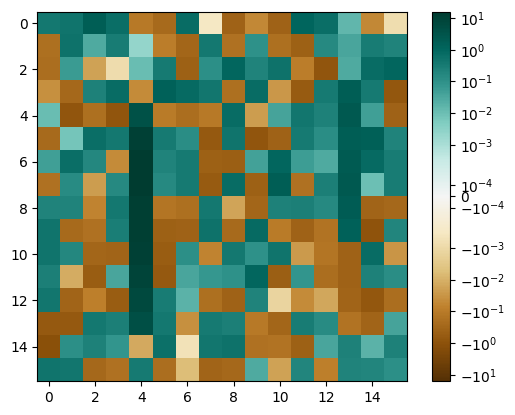

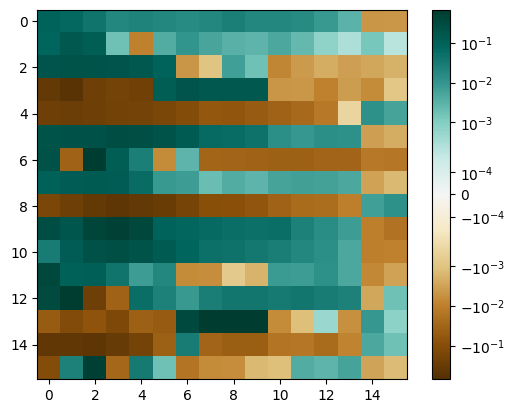

In [ ]:
do_log = True
if isinstance(model, keras.Model):
    for weights in model.weights:
        if do_log:
            if (weights.numpy() < 0).any():
                vmax = abs(weights.numpy()).max()
                vmin = - vmax
                linthr = abs(weights.numpy()).min()
                # linthr = 1e-1
                norm = mcolors.SymLogNorm(linthresh=linthr, vmin=vmin, vmax=vmax)
                cmap = 'BrBG'
            else:
                norm = mcolors.LogNorm()
                cmap = 'viridis'
        else:
            norm = mcolors.Normalize()
            cmap = 'viridis'

        img = plt.imshow(weights.numpy(), norm=norm, cmap=cmap)

        plt.colorbar(img)
        plt.show()

In [ ]:
if isinstance(model, LinearModel):
    %timeit np.dot(t_x(X_test), model.coef_.T)

In [ ]:
if isinstance(model, LinearModel):
    if (model.coef_ < 0).any():
        vmax = abs(model.coef_).max()
        vmin = - vmax
        # linthr = abs(model.coef_).min()
        linthr = 1e-1
        img = plt.imshow(model.coef_, norm=mcolors.SymLogNorm(linthresh=linthr, vmin=vmin, vmax=vmax), cmap='BrBG')
    else:
        # vmax = model.coef_.max()
        # vmin = model.coef_.min()
        img = plt.imshow(model.coef_, norm=mcolors.LogNorm())

    plt.colorbar(img)
    plt.show()

In [ ]:
if isinstance(model, LinearModel):
    np.save('kappa_beta.npy',model.coef_)
    wrmds('/Users/schneider/codes/exo/exorad/verification/HD2/input/ml_coeff', model.coef_.T.flatten(order='F'), dataprec="float64")
    wrmds('/Users/schneider/codes/exo/exorad/verification/fluxes/input/ml_coeff', model.coef_.T.flatten(order='F'), dataprec="float64")
if isinstance(model, XGBRegressor):
    model.save_model('xgboost.json')
elif isinstance(model, keras.Model):
    # model.save('unet_log_simple')
    # model.save('mlp_log')
    for i, weights in enumerate(model.weights):
        np.save(f'mlp_deep_set_{i}.npy', weights.numpy())
        wrmds(f'/Users/schneider/codes/exo/exorad/verification/HD2/input/ml_coeff_{i}', weights.numpy().T, dataprec="float64")
        wrmds(f'/Users/schneider/codes/exo/exorad/verification/fluxes/input/ml_coeff_{i}', weights.numpy().T, dataprec="float64")



In [ ]:
# if isinstance(model, keras.Model):
#     # Convert the model to TensorFlow Lite format
#     converter = tf.lite.TFLiteConverter.from_keras_model(model)
#     tflite_model = converter.convert()

#     # Save the converted model to a file
#     with open('unet_log_simple.tflite', 'wb') as f:
#         f.write(tflite_model)